In [ ]:
# Mount Google Drive to access dataset files
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Define paths to the training, validation, and test datasets
train_folder = '/content/drive/MyDrive/LungCancerDetection/dataset/train'
test_folder = '/content/drive/MyDrive/LungCancerDetection/dataset/test'
validate_folder = '/content/drive/MyDrive/LungCancerDetection/dataset/valid'

# Define paths to the specific classes within the dataset
normal_folder = '/normal'
adenocarcinoma_folder = '/adenocarcinoma'
large_cell_carcinoma_folder = '/large.cell.carcinoma'
squamous_cell_carcinoma_folder = '/squamous.cell.carcinoma'

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout2D, Activation, Lambda, Flatten, LSTM
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import utils

print("Libraries Imported")

# Set the image size for resizing
IMAGE_SIZE = (350, 350)

# Initialize the image data generators for training and testing
print("Reading training images from:", train_folder)
print("Reading validation images from:", validate_folder)

train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)


# Define the batch size for training
batch_size = 8


# Create the training data generator
train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical'
)


# Create the validation data generator
validation_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical'
)


Libraries Imported
Reading training images from: /content/drive/MyDrive/dataset/train
Reading validation images from: /content/drive/MyDrive/datasetvalid
Found 613 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

learning_rate_reduction = ReduceLROnPlateau(monitor='loss', patience=5, verbose=2, factor=0.5, min_lr=0.000001)
early_stops = EarlyStopping(monitor='loss', min_delta=0, patience=6, verbose=2, mode='auto')
checkpointer = ModelCheckpoint(filepath='best_model.hdf5', verbose=2, save_best_only=True, save_weights_only=True)


In [ ]:
OUTPUT_SIZE = 4

pretrained_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
pretrained_model.trainable = False

model = Sequential()
model.add(pretrained_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(OUTPUT_SIZE, activation='softmax'))

print("Pretrained model used:")
pretrained_model.summary()

print("Final model created:")
model.summary()

# Compile the model with an optimizer, loss function, and evaluation metric
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


83683744/83683744 [==============================] - 3s 0us/step
Pretrained model used:
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 350, 350, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 174, 174, 32)         864       ['input_3[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 174, 174, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 bl

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=25,
    epochs=50,
    callbacks=[learning_rate_reduction, early_stops, checkpointer],
    validation_data=validation_generator,
    validation_steps=20
)

print("Final training accuracy =", history.history['accuracy'][-1])
print("Final testing accuracy =", history.history['val_accuracy'][-1])


Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 1.2235 - accuracy: 0.4467
Epoch 1: val_loss improved from inf to 1.08683, saving model to best_model.hdf5
25/25 [==============================] - 201s 8s/step - loss: 1.2235 - accuracy: 0.4467 - val_loss: 1.0868 - val_accuracy: 0.5437 - lr: 0.0010
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 1.0109 - accuracy: 0.5400
Epoch 2: val_loss improved from 1.08683 to 1.01950, saving model to best_model.hdf5
25/25 [==============================] - 251s 10s/step - loss: 1.0109 - accuracy: 0.5400 - val_loss: 1.0195 - val_accuracy: 0.5250 - lr: 0.0010
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.8993 - accuracy: 0.6200
Epoch 3: val_loss improved from 1.01950 to 0.86878, saving model to best_model.hdf5
25/25 [==============================] - 252s 10s/step - loss: 0.8993 - accuracy: 0.6200 - val_loss: 0.8688 - val_accuracy: 0.5938 - lr: 0.0010
Epoch 4/50
25/25 [=====================

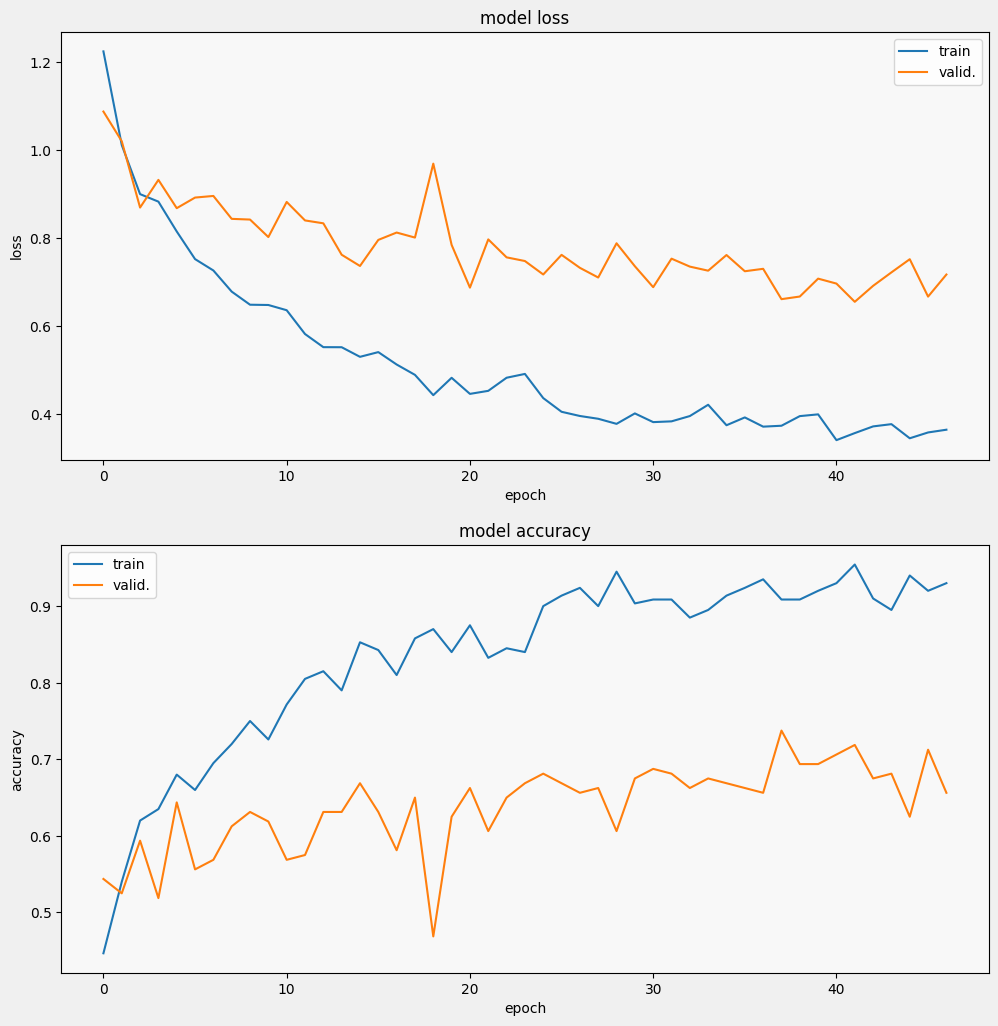

In [ ]:
def display_training_curves(training, validation, title, subplot):
    if subplot % 10 == 1:
        plt.subplots(figsize=(10, 10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model ' + title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 212)


In [ ]:
model.save('/content/drive/MyDrive/dataset/best_model.hdf5')

1/1 [==============================] - 2s 2s/step
The image belongs to class: squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa


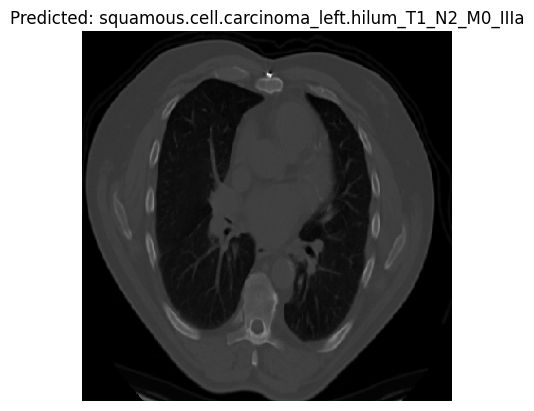

In [ ]:

from tensorflow.keras.preprocessing import image
import numpy as np

def load_and_preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

img_path = '/content/sq.png'
img = load_and_preprocess_image(img_path, IMAGE_SIZE)

predictions = model.predict(img)
predicted_class = np.argmax(predictions[0])

class_labels = list(train_generator.class_indices.keys())
predicted_label = class_labels[predicted_class]


print(f"The image belongs to class: {predicted_label}")

plt.imshow(image.load_img(img_path, target_size=IMAGE_SIZE))
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()